In [1]:
# %% Import packages
from pprint import pprint
from itertools import chain, compress, product
from functools import reduce, partial, lru_cache
from glob import iglob
from typing import Generator

from numba import jit
from yaml import safe_load
from cytoolz import compose, merge_with
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row, DataFrame, functions as f
from dltools import load_combiner
from dltools.sacla import restructure, load_analyzer

In [2]:
# %% Load PySpark
builder = (
    SparkSession
    .builder
    .config("spark.executor.memory", "16g")
    .config("spark.driver.memory", "16g")
    .config("spark.driver.maxResultSize", "4g")
    .config(        
        "spark.jars.packages",
        "org.apache.hadoop:hadoop-aws:2.7.0,"
        "org.mongodb.spark:mongo-spark-connector_2.11:2.3.1,"
        "org.diana-hep:spark-root_2.11:0.1.15,"
    )
)

print("Loading PySpark...")
spark = builder.getOrCreate()
print("Done!")

Loading PySpark...
Done!


In [3]:
# %% Load data
from pyspark.sql.types import (
    ArrayType, BooleanType, LongType, StructField, StructType, DoubleType,
)
from dltools import SpkHits


print("Loading data...")
df = (
    spark
    .read
    .format("com.mongodb.spark.sql.DefaultSource")
    .option("uri", "mongodb://mongodb/sacla_2017b8065.resorted")
    .option("pipeline", """[
        {
            $match: {
                aq: {$in: [35, 36]},
            },
        },
        {
            $project: {
                tag: true,
                hits: {
                    $filter: {
                        input: "$hits",
                        as: "item",
                        cond: {$lte: ["$$item.flag", 13]},
                    },
                },
            },
        },
    ]""")
    .schema(
        StructType([
            StructField("tag", LongType()),
            StructField("hits", SpkHits)
        ])
    )
    .load()
#     .cache()
)
df.printSchema()
# df.show()
print("Done!")

Loading data...
root
 |-- tag: long (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- t: double (nullable = false)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- as_: map (nullable = false)
 |    |    |    |-- key: string
 |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |-- ke: double (nullable = false)
 |    |    |-- flag: integer (nullable = true)

Done!


In [5]:
from cov import cov11_simple, cov21_inapool


pipico = cov11_simple(
    df.select(f.col("hits.t").alias("t")),
    "t",
)
fish = cov21_inapool(
    df.select(f.col("hits.t").alias("t"),
              f.col("hits.y").alias("y")),
    "t", "y",
)

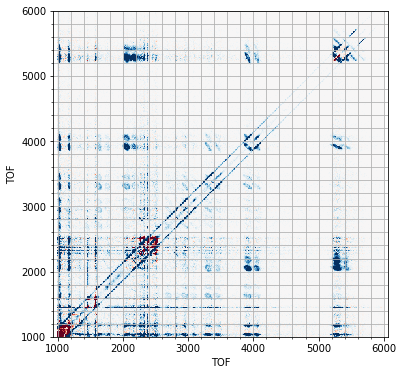

In [6]:
fr, to, nbins = 1000, 6000, 500
img = pipico(fr, to, nbins)["Cov[X,Y]"]
tbins = np.linspace(fr, to, nbins + 1)
clim = 2e-4

plt.figure(figsize=(6, 6))
plt.xlabel("TOF")
plt.ylabel("TOF")
plt.pcolormesh(tbins, tbins, img.T, cmap="RdBu")
plt.clim(-clim, clim)
plt.minorticks_on()
plt.grid(True, which="both")
plt.axis("equal")
plt.show()

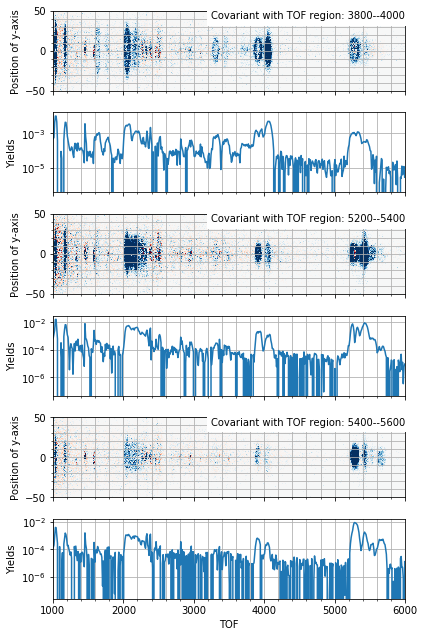

In [7]:
fr, to, nbins = 1000, 6000, 500
tbins = np.linspace(fr, to, nbins + 1)
tcenters = (tbins[1:] + tbins[:-1]) / 2
rbins = np.linspace(-50, 50, 101)
clim = 5e-5

plt.figure(figsize=(6, 9))
plt.subplot(611)
plt.text(1, 1, "Covariant with TOF region: 3800--4000",
         horizontalalignment="right",
         verticalalignment="top",
         transform=plt.gca().transAxes,
         bbox={"facecolor": "w", "edgecolor": "w"})
plt.ylabel("Position of y-axis")
img = fish(
    fr, to, nbins,
    fr01=-50, to01=50, nbins01=101,
    fr1=3800, to1=4000,
)["Cov[X,Y]"][..., 0]
plt.pcolormesh(tbins, rbins, img.T, cmap="RdBu")
plt.clim(-clim, clim)
plt.minorticks_on()
plt.grid(True, which="both")
plt.gca().label_outer()

plt.subplot(612)
plt.ylabel("Yields")
plt.plot(tcenters, img.sum(1))
plt.xlim(1000, 6000)
plt.yscale("log")
plt.minorticks_on()
plt.grid(True, which="both")
plt.gca().label_outer()

plt.subplot(613)
plt.text(1, 1, "Covariant with TOF region: 5200--5400",
         horizontalalignment="right",
         verticalalignment="top",
         transform=plt.gca().transAxes,
         bbox={"facecolor": "w", "edgecolor": "w"})
plt.ylabel("Position of y-axis")
img = fish(
    fr, to, nbins,
    fr01=-50, to01=50, nbins01=101,
    fr1=5200, to1=5400,
)["Cov[X,Y]"][..., 0]
plt.pcolormesh(tbins, rbins, img.T, cmap="RdBu")
plt.clim(-clim, clim)
plt.minorticks_on()
plt.grid(True, which="both")
plt.gca().label_outer()

plt.subplot(614)
plt.ylabel("Yields")
plt.plot(tcenters, img.sum(1))
plt.xlim(1000, 6000)
plt.yscale("log")
plt.minorticks_on()
plt.grid(True, which="both")
plt.gca().label_outer()

plt.subplot(615)
plt.text(1, 1, "Covariant with TOF region: 5400--5600",
         horizontalalignment="right",
         verticalalignment="top",
         transform=plt.gca().transAxes,
         bbox={"facecolor": "w", "edgecolor": "w"})
plt.ylabel("Position of y-axis")
img = fish(
    fr, to, nbins,
    fr01=-50, to01=50, nbins01=101,
    fr1=5400, to1=5600,
)["Cov[X,Y]"][..., 0]
plt.pcolormesh(tbins, rbins, img.T, cmap="RdBu")
plt.clim(-clim, clim)
plt.minorticks_on()
plt.grid(True, which="both")
plt.gca().label_outer()

plt.subplot(616)
plt.xlabel("TOF")
plt.ylabel("Yields")
plt.plot(tcenters, img.sum(1))
plt.xlim(1000, 6000)
plt.yscale("log")
plt.minorticks_on()
plt.grid(True, which="both")
# plt.gca().label_outer()

plt.tight_layout()
plt.show()